# Environmental contour

Brief example that computes a sea state contour from the PNBOIA data (https://www.marinha.mil.br/chm/dados-do-goos-brasil/pnboia-mapa) using the Library virocon (https://github.com/virocon-organization/virocon).

A contour implements a method to define multivariate extremes based on a joint probabilistic model of variables 
like significant wave height, wind speed or spectral peak period. Contour curves or surfaces for more than two 
environmental parameters give combination of environmental parameters which approximately describe the various 
actions corresponding to the given exceedance probability. See: 
https://virocon.readthedocs.io/en/latest/definitions.html

### Bouy data ⛵

First, donwload a **buoy sea state data** set from https://www.marinha.mil.br/chm/dados-do-goos-brasil/pnboia-mapa

### Running this notebook 🏃

This notebbook runs entirely in the browser with JupyterLite.

Go to https://jupyterlite.readthedocs.io/en/latest/_static/lab/index.html 

Upload this **notebook** (ipynb file) and the **buoy data** (txt file) into the browser's JupiterLite directory.

### User INPUTS 👩🏻‍💻

Define the contour’s return period **tr**, environmental state duration **ts** and number of points **nSamples** for the simulations.

In [1]:
# Return period in years. Describes the average time period between two consecutive environmental states 
# that exceed a contour. In the univariate case the contour is a threshold.
tr = 50
# Sea state duration in hours. Time period for which an env
ts = 1
# Number of sea states for simulation
nSamples = 5

Set the **input file name** with buoy data. Here, we use a dataset from BOIA SANTOS.

In [2]:
inpute_file_name = 'historico_santos' # Buoy File name - Buoy SANTOS 25°26'37''S 45°02'17''W

### Visualizing data in the notebook ✨
Restart Kernel and Run All Cells by clicking on the button &#x1F782;&#x1F782;

### Python code ⚙️

Before we start, we install some libraries

In [3]:
%pip install -q virocon

Note: you may need to restart the kernel to use updated packages.


Import the required packages.

In [4]:
import matplotlib.pyplot as plt
import pandas as pd
import csv
import os
import datetime
import numpy as np
from virocon import (
    read_ec_benchmark_dataset,
    get_OMAE2020_Hs_Tz,
    GlobalHierarchicalModel,
    IFORMContour,
    IFORMContour,
    ISORMContour,
    DirectSamplingContour,
    HighestDensityContour,
    plot_2D_contour,
)

Read data and delete negative values.

In [5]:
input_file_txt = inpute_file_name + '.txt'

# Output CSV file name formatted to be used with virocon functions
output_file_csv = inpute_file_name + '_comma.csv'
# Output TXT file name formatted to be used with virocon functions
output_file_txt = inpute_file_name + '_comma.txt'

# Wvht: significant wave height (m)
# Dpd:  peak wave period (s)
df = pd.read_csv(input_file_txt, sep=',', usecols=['# Datetime', 'Wvht', 'Dpd'])

# Delete negative values
df = df.drop(df.index[df['Wvht'] < 0])
df = df.drop(df.index[df['Dpd'] < 0])

print(df)

                # Datetime  Wvht   Dpd
0      2011-04-12 19:00:00  1.62  11.1
1      2011-04-12 20:00:00  1.62   6.9
2      2011-04-12 21:00:00  1.63   6.9
3      2011-04-12 22:00:00  1.57  11.8
4      2011-04-12 23:00:00  1.47   6.7
...                    ...   ...   ...
59489  2018-12-09 04:00:00  3.61  14.3
59490  2018-12-09 05:00:00  3.27  14.3
59491  2018-12-09 06:00:00  3.61  14.3
59492  2018-12-09 07:00:00  3.19  14.3
59493  2018-12-09 08:00:00  3.46  14.3

[56110 rows x 3 columns]


Prepare data to be used by virocon.

In [6]:
# Convert datetime format
dfAux = []
for index, row in df.iterrows():
    timeSTP = pd.Timestamp(row['# Datetime'])
    dfAux.append(timeSTP.strftime('%Y-%m-%d-%H'))

# Creating DataFrame
d2 = {'# Datetime':dfAux}
df2 = pd.DataFrame(d2)
# Assigning column of df2 to a new column of df
df['# Datetime'] = df2['# Datetime']

row_count = df.shape[0] # Returns number of rows
col_count = df.shape[1] # Returns number of columns
print('Number of valid data', row_count)

# Save temp file
df.to_csv('temp.txt',index=False)

# Rename Header Columns in CSV File
with open('temp.txt', 'r', encoding='utf-8') as file:
    data = file.readlines()
data[0] = 'time (YYYY-MM-DD-HH),significant wave height (m),zero-up-crossing period (s)\n'
with open('temp.txt', 'w', encoding='utf-8') as file:
    file.writelines(data)

# Check if ouputfile already exists, then delete it:
if os.path.exists(output_file_csv):
    os.remove(output_file_csv)

# Renaming the file
os.rename('temp.txt', output_file_csv)

# Load sea state measurements. 
df = pd.read_csv(output_file_csv, index_col=0)

# Remove Rows with empty cells
new_df = df.dropna()

# Save as txt file without column ID and using semicolons
new_df.to_csv(output_file_txt, sep=';')

print('Input file successfully changed to be used with package virocon')

Number of valid data 56110
Input file successfully changed to be used with package virocon


Load the sea state data set.

In [7]:
data = read_ec_benchmark_dataset(output_file_txt)

Define the structure of the joint distribution model.

In [8]:
dist_descriptions, fit_descriptions, semantics = get_OMAE2020_Hs_Tz()
model = GlobalHierarchicalModel(dist_descriptions)

Estimate the model's parameter values (fitting).

In [9]:
model.fit(data, fit_descriptions=fit_descriptions)

Compute IFORM and ISORM contours with a return period of **tr** years.
- IFORM: inverse first-order reliability method
- ISORM: inverse second-order reliability method. More conservative

In [10]:
alpha = 1.0 / (tr * 365.25 * 24.0 / ts)

In [11]:
iform_contour = IFORMContour(model, alpha)

In [12]:
isorm_contour = ISORMContour(model, alpha)

Compute the **Design period range** and select **nSamples** points.

In [13]:
waveHeight_IF = iform_contour.coordinates[:,0]
wavePeriod_IF = iform_contour.coordinates[:,1]
waveHeight_IS = isorm_contour.coordinates[:,0]
wavePeriod_IS = isorm_contour.coordinates[:,1]

# Number of points
nPts_IF = waveHeight_IF.size
nPts_IS = waveHeight_IS.size
# Interval of 5 points
intPts_IF = int(nPts_IF/nSamples)
intPts_IS = int(nPts_IS/nSamples)
# Maximum wave height (n-year significant wave height, Hs,n), index and respective period
maxH_IF = np.amax(waveHeight_IF)
maxHid_IF = np.argmax(waveHeight_IF)
maxHperiod_IF = wavePeriod_IF[maxHid_IF]
maxH_IS = np.amax(waveHeight_IS)
maxHid_IS = np.argmax(waveHeight_IS)
maxHperiod_IS = wavePeriod_IS[maxHid_IS]

# a_ = np.sqrt(6.50) # 2.55
# b_ = np.sqrt(11.0) # 3.32
# Peak spectral period
# Valamanesh et al., 2015. Multivariate analysis of extreme metocean conditions for offshore wind turbines
a_ = 11.7 / np.sqrt(9.81) # 3.74
b_ = 17.2 / np.sqrt(9.81) # 5.49
# # IEC 2009. Wind Turbines Part 3: Design requirements for offshore wind turbines
# a_ = 11.1 / np.sqrt(9.81) # 3.54
# b_ = 14.3 / np.sqrt(9.81) # 4.57
T1_IF = a_ * np.sqrt(maxH_IF)
T2_IF = b_ * np.sqrt(maxH_IF)
T1_IS = a_ * np.sqrt(maxH_IS)
T2_IS = b_ * np.sqrt(maxH_IS)

# Minimum wave period, index
minT_IF = np.amin(wavePeriod_IF)
minTid_IF = np.argmin(wavePeriod_IF)
minT_IS = np.amin(wavePeriod_IS)
minTid_IS = np.argmin(wavePeriod_IS)
# Maximum wave period, index and respective height
maxT_IF = np.amax(wavePeriod_IF)
maxTid_IF = np.argmax(wavePeriod_IF)
maxTheight_IF = waveHeight_IF[maxHid_IF]
maxT_IS = np.amax(wavePeriod_IS)
maxTid_IS = np.argmax(wavePeriod_IS)
maxTheight_IS = waveHeight_IS[maxHid_IS]

# Period interval
periodInt_IF = (maxT_IF - minT_IF)/nSamples
# periodInt_IF = (maxT_IF - maxHperiod_IF)/2.0
periodInt_IS = (maxT_IS - minT_IS)/nSamples
# periodInt_IS = (maxT_IS - maxHperiod_IS)/2.0


# IFORM
ids_IF = []
# Return index
# Search right points
for ii in range(1, nSamples):
    if ii > nSamples/2:
        break
    idAux1 = np.where(np.logical_and(wavePeriod_IF > maxHperiod_IF + (ii - 0.05)*periodInt_IF, wavePeriod_IF < maxHperiod_IF + (ii + 0.05)*periodInt_IF))
    # idAux1 = np.where(np.logical_and(wavePeriod_IF > 0.95*T1_IF, wavePeriod_IF < 1.05*T1_IF))
    # Find max Height for the period
    maxHaux = 0
    for jj in idAux1[0]:
        if waveHeight_IF[jj] > maxHaux:
            maxHaux = waveHeight_IF[jj]
            idMaxH = jj
    ids_IF.append(idMaxH)

del ii

# Search left point
for ii in range(1, nSamples):
    if ii > nSamples/2:
        break
    idAux2 = np.where(np.logical_and(wavePeriod_IF > maxHperiod_IF - (ii + 0.05)*periodInt_IF, wavePeriod_IF < maxHperiod_IF - (ii - 0.05)*periodInt_IF))
    # idAux2 = np.where(np.logical_and(wavePeriod_IF > 0.95*T2_IF, wavePeriod_IF < 1.05*T2_IF))
    # Find max Height for the period
    maxHaux = 0
    for jj in idAux2[0]:
        if waveHeight_IF[jj] > maxHaux:
            maxHaux = waveHeight_IF[jj]
            idMaxH = jj
    ids_IF.append(idMaxH)

wavePts_IF = []
wavePts_IF.append(waveHeight_IF[0])
for xx in ids_IF:
    wavePts_IF.append(waveHeight_IF[xx])
# wavePts_IF.append(waveHeight_IF[maxTid_IF])
periodPts_IF = []
periodPts_IF.append(wavePeriod_IF[0])
del xx
for xx in ids_IF:
    periodPts_IF.append(wavePeriod_IF[xx])
# periodPts_IF.append(wavePeriod_IF[maxTid_IF])

periodOutput_IF = ['{:.2f}'.format(elem) for elem in periodPts_IF]
waveOutput_IF = ['{:.2f}'.format(elem) for elem in wavePts_IF]

# ISORM
ids_IS = []
# Return index
# Search right points
for ii in range(1, nSamples):
    if ii > nSamples/2:
        break
    idAux1 = np.where(np.logical_and(wavePeriod_IS > maxHperiod_IS + (ii - 0.05)*periodInt_IS, wavePeriod_IS < maxHperiod_IS + (ii + 0.05)*periodInt_IS))
    # idAux1 = np.where(np.logical_and(wavePeriod_IS > 0.95*T1_IS, wavePeriod_IS < 1.05*T1_IS))
    # Find max Height for the period
    maxHaux = 0
    for jj in idAux1[0]:
        if waveHeight_IS[jj] > maxHaux:
            maxHaux = waveHeight_IS[jj]
            idMaxH = jj
    ids_IS.append(idMaxH)

del ii

# Search left point
for ii in range(1, nSamples):
    if ii > nSamples/2:
        break
    idAux2 = np.where(np.logical_and(wavePeriod_IS > maxHperiod_IS - (ii + 0.05)*periodInt_IS, wavePeriod_IS < maxHperiod_IS - (ii - 0.05)*periodInt_IS))
    # idAux2 = np.where(np.logical_and(wavePeriod_IS > 0.95*T2_IS, wavePeriod_IS < 1.05*T2_IS))
    # Find max Height for the period
    maxHaux = 0
    for jj in idAux2[0]:
        if waveHeight_IS[jj] > maxHaux:
            maxHaux = waveHeight_IS[jj]
            idMaxH = jj
    ids_IS.append(idMaxH)

wavePts_IS = []
wavePts_IS.append(waveHeight_IS[0])
for xx in ids_IS:
    wavePts_IS.append(waveHeight_IS[xx])
# wavePts_IS.append(waveHeight_IS[maxTid_IS])
periodPts_IS = []
periodPts_IS.append(wavePeriod_IS[0])
del xx
for xx in ids_IS:
    periodPts_IS.append(wavePeriod_IS[xx])
# periodPts_IS.append(wavePeriod_IS[maxTid_IS])

periodOutput_IS = ['{:.2f}'.format(elem) for elem in periodPts_IS]
waveOutput_IS = ['{:.2f}'.format(elem) for elem in wavePts_IS]

print('IFORM T1: ' + '{:.3f}s'.format(T1_IF))
print('IFORM T2: ' + '{:.3f}s'.format(T2_IF))
# print('IFORM Interval period: ' + '{:.3f}s'.format(periodInt_IF))
print('IFORM Maximum wave height: ' + '{:.3f}m'.format(maxH_IF))
print('IFORM Period of the maximum wave height: ' + '{:.3f}s'.format(maxHperiod_IF))
# print('IFORM Wave Periods[s]: ', periodOutput_IF)
# print('IFORM Wave heights[m]: ', waveOutput_IF)
print('ISORM T1' + ' = {:.3f}s'.format(T1_IS))
print('ISORM T2' + ' = {:.3f}s'.format(T2_IS))
# print('ISORM Interval period: ' + '{:.3f}s'.format(periodInt_IS))
print('ISORM Maximum wave height: ' + '{:.3f}m'.format(maxH_IS))
print('ISORM Period of the maximum wave height: ' + '{:.3f}s'.format(maxHperiod_IS))
# print('ISORM Wave Periods[s]: ', periodOutput_IS)
# print('ISORM Wave heights[m]: ', waveOutput_IS)

IFORM T1: 11.228s
IFORM T2: 16.506s
IFORM Maximum wave height: 9.034m
IFORM Period of the maximum wave height: 15.088s
ISORM T1 = 12.088s
ISORM T2 = 17.770s
ISORM Maximum wave height: 10.471m
ISORM Period of the maximum wave height: 15.864s


Plot the contours and save the figure.

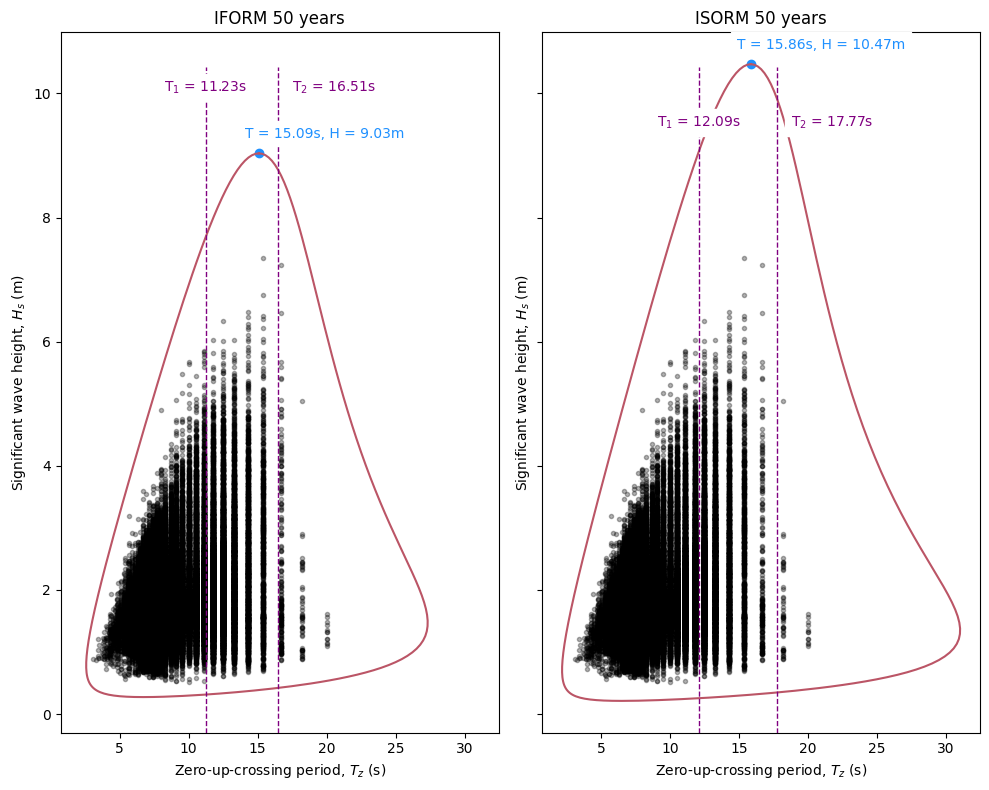

Figure saved in folder 'figures'


In [14]:
plots_n = []
# Plot the contour
fig, axs = plt.subplots(1, 2, figsize=[10, 8], sharex=True, sharey=True)
# fig, axs = plt.subplots(1, 2, figsize=[10, 8], sharex=True, sharey=True, gridspec_kw={'width_ratios': [1000, 1]})
plot_2D_contour(iform_contour, data, semantics=semantics, ax=axs[0], swap_axis=True)
plot_2D_contour(isorm_contour, data, semantics=semantics, ax=axs[1], swap_axis=True)

# Plot the periods limits
# only one line may be specified; ymin & ymax specified as a percentage of y-range
axs[0].axvline(x=T1_IF, ymin=0.00, ymax=0.95, color='purple', ls='--', lw=1)
axs[0].text(T1_IF-3.0, maxH_IF + 1.0, r'T$_{1}$' + ' = {:.2f}s'.format(T1_IF), backgroundcolor='w', color='purple')
axs[0].axvline(x=T2_IF, ymin=0.00, ymax=0.95, color='purple', ls='--', lw=1)
axs[0].text(T2_IF+1.0, maxH_IF + 1.0, r'T$_{2}$' + ' = {:.2f}s'.format(T2_IF), backgroundcolor='w', color='purple')
axs[1].axvline(x=T1_IS, ymin=0.00, ymax=0.95, color='purple', ls='--', lw=1)
axs[1].text(T1_IS-3.0, maxH_IS - 1.0, r'T$_{1}$' + ' = {:.2f}s'.format(T1_IS), backgroundcolor='w', color='purple')
axs[1].axvline(x=T2_IS, ymin=0.00, ymax=0.95, color='purple', ls='--', lw=1)
axs[1].text(T2_IS+1.0, maxH_IS - 1.0, r'T$_{2}$' + ' = {:.2f}s'.format(T2_IS), backgroundcolor='w', color='purple')

# Plot the maximum wave height
axs[0].scatter(maxHperiod_IF, maxH_IF, color='dodgerblue') # royalblue
axs[0].text(maxHperiod_IF-1.0, maxH_IF+0.25, 'T = {:.2f}s, H = {:.2f}m'.format(maxHperiod_IF, maxH_IF), backgroundcolor='w', color='dodgerblue') # royalblue
axs[1].scatter(maxHperiod_IS, maxH_IS, color='dodgerblue') # royalblue
axs[1].text(maxHperiod_IS-1.0, maxH_IS+0.25, 'T = {:.2f}s, H = {:.2f}m'.format(maxHperiod_IS, maxH_IS), backgroundcolor='w', color='dodgerblue') # royalblue

titles = ['IFORM ' + str(tr) + ' years', 'ISORM ' + str(tr) + ' years']
for i, (ax, title) in enumerate(zip(axs, titles)):
    ax.set_title(title)
plt.tight_layout()

fig = plt.gcf() # get current figure

# Make directory
fig_directory_name = 'figures'
current_directory = os.getcwd()
final_directory = os.path.join(current_directory, fig_directory_name)
if not os.path.exists(final_directory):
    os.makedirs(final_directory)

# Save Figure
fig_name = inpute_file_name + '_tr' + str(tr) + 'years_envirom_countor'
fig.savefig(fig_directory_name + '/' + fig_name + '.png')
plt.show()
plt.close(fig)    # close the figure window

print('Figure saved in folder \'{}\''.format(fig_directory_name))